In [1]:
import boto3
import cv2
import collections
import copy
# import dlib
import glob
from imutils import face_utils
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import pickle
import pymysql
import random
from scipy import stats
from datetime import datetime

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

import tensorflow as tf
print(tf.__version__)

import pytube
import xml.etree.ElementTree as ET

from keras_vggface.vggface import VGGFace
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, ConvLSTM2D, MaxPooling3D, Reshape, LSTM, Activation
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dropout, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications import ResNet50
from keras.callbacks import CSVLogger

from keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'imutils'

In [2]:
NUM_FRAMES_PER_FRAME_SEQUENCE = 6


SAMPLES_PER_CLASS_TRAIN = 6
SAMPLES_PER_CLASS_TEST = 2

# Parse SSBD dataset XML files.

In [5]:
urls_to_download = []
title_to_behaviors = {}
import os 
files = os.listdir('/ssbd-release/Annotations/')
for file in files:
    tree = ET.parse(
        'ssbd-release/Annotations/' + file)
    root = tree.getroot()
    title = root.attrib['keyword']
    print(root.attrib)
    for child in root:
        print(child.tag, child.text)
        if child.tag == 'url':
            urls_to_download.append(child.text)
        if child.tag == 'behaviours':
            behaviors = []
            for behavior in child:
                start_min = None
                start_sec = None
                end_min = None
                end_sec = None
                category = None
                bodypart = None
                for prop in behavior:
                    print(prop.tag, prop.text)
                    if prop.tag == 'time':
                        if ':' in prop.text:
                            start_time = prop.text.split(':')[0]
                            end_time = prop.text.split(':')[1]
                        elif '-' in prop.text:
                            start_time = prop.text.split('-')[0]
                            end_time = prop.text.split('-')[1]
                        print('START AND END TIME', start_time, end_time)
                        print(prop.text)
                        if len(start_time) < 3:
                            start_min = '00'
                            start_sec = start_time
                        elif len(end_time) < 3:
                            end_min = '00'
                            end_sec = end_time
                        else:
                            start_min = start_time[:2]
                            start_sec = start_time[2:4]
                            end_min = end_time[:2]
                            end_sec = end_time[2:4]
                    elif prop.tag == 'category':
                        category = prop.text
                    elif prop.tag == 'bodypart':
                        bodypart = prop.text
                behaviors.append( (start_min, start_sec, end_min, end_sec, category, bodypart) )
            title_to_behaviors[title] = behaviors     
            print()
    print()
    print()
    print('------------------')
    print()
    print()

FileNotFoundError: [Errno 2] No such file or directory: '/ssbd-release/Annotations/'

In [4]:
title_to_behaviors

{'Autism Giggles squeals head spinning and banging': [('00',
   '10',
   '00',
   '15',
   'spinning',
   'head')],
 'Autistic (Aspergers) 8 year old over stimulated - Stimming': [('00',
   '04',
   '00',
   '12',
   'spinning',
   'body'),
  ('00', '28', '00', '47', 'spinning', 'body'),
  ('00', '58', '01', '04', 'spinning', 'body')],
 'Madelyn hand flapping': [('00', '07', '00', '16', 'armflapping', 'hand')],
 '1 year old boy head banging': [('00',
   '01',
   '00',
   '04',
   'headbanging',
   'head')],
 'Excessive head banging and tantrum': [('00',
   '02',
   '00',
   '12',
   'headbanging',
   'head')],
 'Diagnosed Autism Spinning And flapping, flapping And more spinning': [('00',
   '51',
   '00',
   '58',
   'spinning',
   'body')],
 'My Son Spinning - AUTISM': [('00', '01', '02', '35', 'spinning', 'body')],
 'Autistic behaviors - son rolling/spinning in grass': [('00',
   '26',
   '00',
   '43',
   'spinning',
   'body')],
 'Autism - Ayden Spinning': [('00', '10', '00', '20',

# --------------------------------------------------------------

# RARELY RUN THIS!!! Download SSBD dataset from YouTube.

In [ ]:
for url in urls_to_download:
    print(url)
    try:
        youtube = pytube.YouTube(url)
        video = youtube.streams.first()
        video.download('RRB_datasets/SSBD/videos/')
    except:
        print('That video didn\'t work out.')

# --------------------------------------------------------------

# --------------------------------------------------------------

# RARELY RUN THIS!!! Extract relevant subsets of video.

In [ ]:
def get_time_difference(start_min, start_sec, end_min, end_sec):
    from datetime import datetime
    
    s1 = start_min + ':' + start_sec
    s2 = end_min + ':' + end_sec
    FMT = '%M:%S'
    tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
    return '0' + str(tdelta)
    

behavior_to_curr_count = collections.defaultdict(int)
for title in title_to_behaviors:
    
    prev_end_min = '00'
    prev_end_sec = '00'
    is_first_interval = True
    
    for behavior in title_to_behaviors[title]:
        start_min = behavior[0]
        start_sec = behavior[1]
        end_min = behavior[2]
        end_sec = behavior[3]
        name = behavior[4] + '_' + behavior[5]
        
        if end_min == None or end_sec == None:
            time_diff = '00:00:01'
        else:
            time_diff = get_time_difference(start_min, start_sec, end_min, end_sec)
        
        behavior_to_curr_count[name] += 1
        
        full_title = ''.join([ p + '\ ' for p in title.split(' ')])[:-2] + '.mp4'
        
        # Create behavior of interest video clip.
        full_cmd = 'ffmpeg -ss 00:' + str(start_min) + ':' + str(start_sec) + ' -i RRB_datasets/SSBD/videos/'
        full_cmd += full_title + ' -to '+ time_diff + ' -c copy '
        full_cmd += 'RRB_datasets/Processed_Videos/' + name + '_' + str(behavior_to_curr_count[name]) + '.mp4'
        print(full_cmd)
        os.system(full_cmd)
        
        # Create normal behavior video clip.
        try:
            time_diff = get_time_difference(prev_end_min, prev_end_sec, start_min, start_sec)
            full_cmd = 'ffmpeg -ss 00:' + str(prev_end_min) + ':' + str(prev_end_sec) + ' -i RRB_datasets/SSBD/videos/'
            full_cmd += full_title + ' -to '+ time_diff + ' -c copy '
            full_cmd += 'RRB_datasets/Processed_Videos/' + 'normal' + '_' + str(behavior_to_curr_count['normal']) + '.mp4'
            print(full_cmd)
            os.system(full_cmd)
        except:
            continue
        
        behavior_to_curr_count['normal'] += 1
        prev_end_min = end_min
        prev_end_sec = end_sec
        
        print()
        print()

# --------------------------------------------------------------

# ---

# OPTION 1: POSE REPRESENTATION

# ---

# RARELY RUN THIS!!! Setup pose estimation stuff.

In [5]:
import sys
sys.path.insert(1, '../keras_Realtime_Multi-Person_Pose_Estimation/')

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

In [6]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

In [7]:
weights_path = '../keras_Realtime_Multi-Person_Pose_Estimation/model.h5' # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

In [8]:
def bounding_box(points, in_shape):
    x_coordinates, y_coordinates = zip(*points)
    
    bounding_pts = [[min(x_coordinates), min(y_coordinates)], [max(x_coordinates), max(y_coordinates)]]
    
    return bounding_pts

# RARELY RUN THIS!!! Read in frame sequences as input.

In [9]:
# Specify the paths for the 2 files
protoFile = 'pose_deploy_linevec_faster_4_stages.prototxt'
weightsFile = 'pose_iter_160000.caffemodel'

# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)


In [74]:
armflapping_hand_sequences = []
headbanging_head_sequences = []
normal_sequences = []
spinning_body_sequences = []
spinning_head_sequences = []

FRAME RATE (FPS):  14.767
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new fra

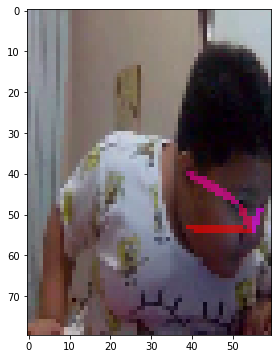

resized size dataset:  (80, 60, 3)


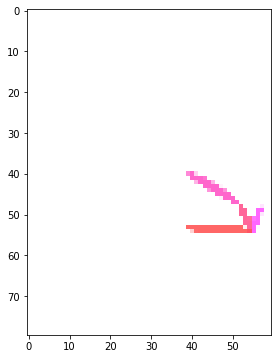

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  2
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


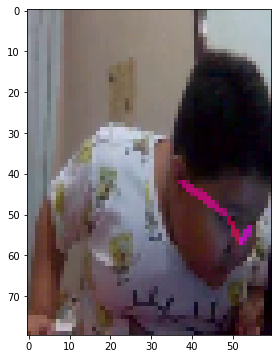

resized size dataset:  (80, 60, 3)


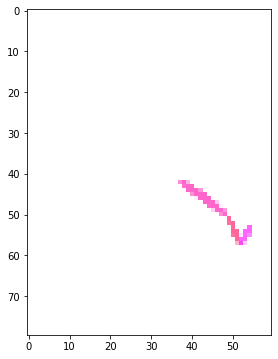

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  1
SUBSET LEN AFTER:  0
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


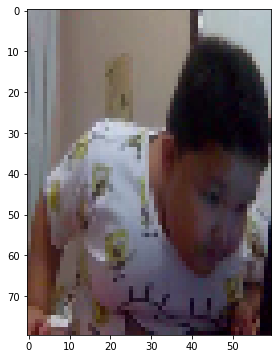

resized size dataset:  (80, 60, 3)


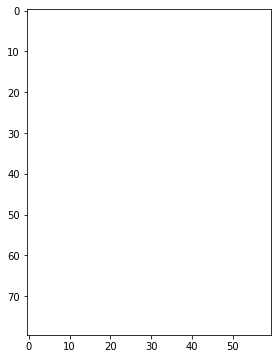

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  1
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


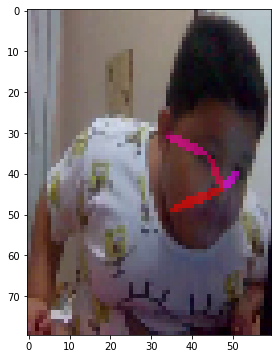

resized size dataset:  (80, 60, 3)


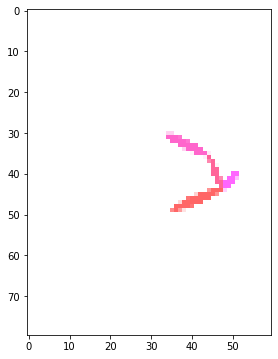

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
found = 2
SUBSET LEN BEFORE:  3
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


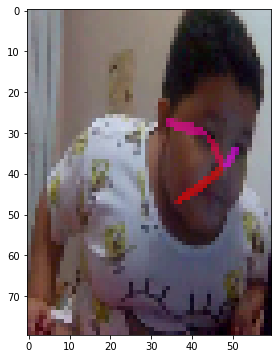

resized size dataset:  (80, 60, 3)


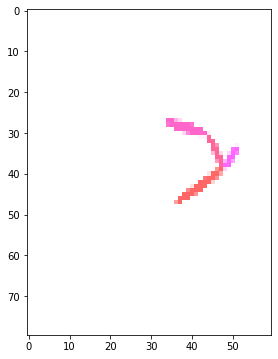

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  2
SUBSET LEN AFTER:  2
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


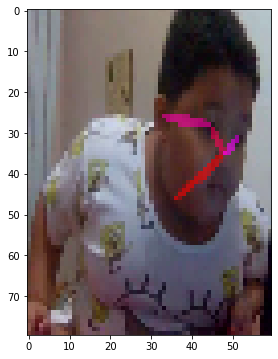

resized size dataset:  (80, 60, 3)


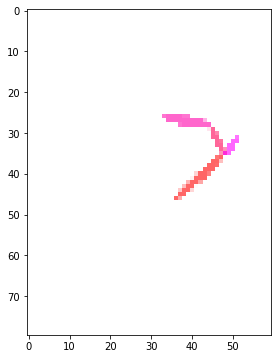

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  1
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


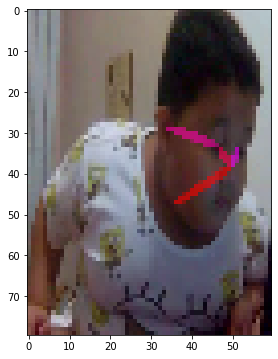

resized size dataset:  (80, 60, 3)


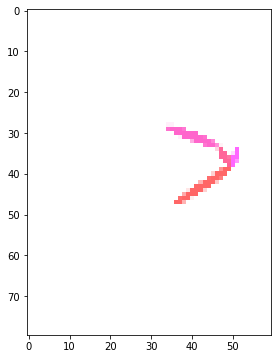

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
found = 2
SUBSET LEN BEFORE:  2
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


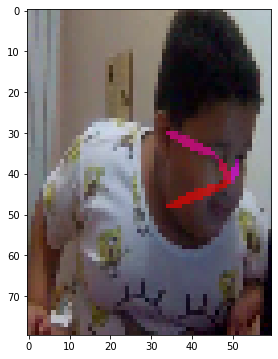

resized size dataset:  (80, 60, 3)


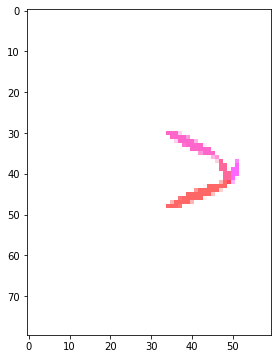

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  2
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


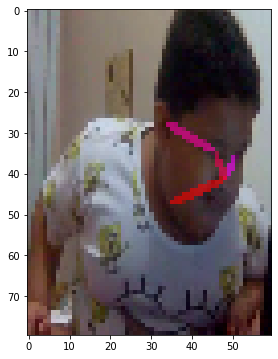

resized size dataset:  (80, 60, 3)


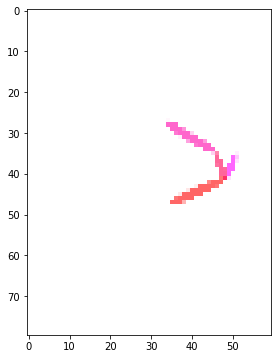

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  2
SUBSET LEN AFTER:  2
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


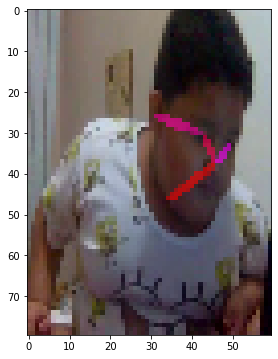

resized size dataset:  (80, 60, 3)


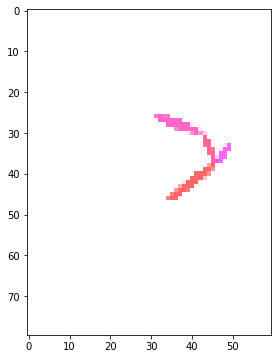

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  1
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


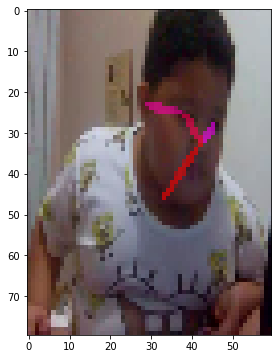

resized size dataset:  (80, 60, 3)


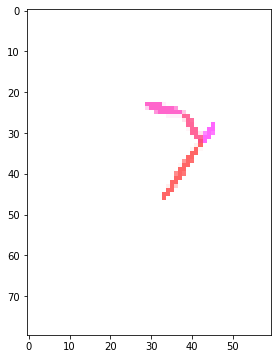

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  1
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


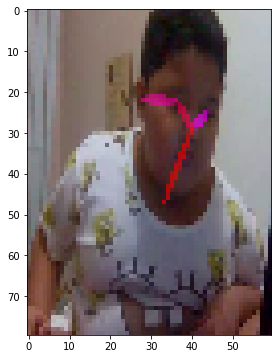

resized size dataset:  (80, 60, 3)


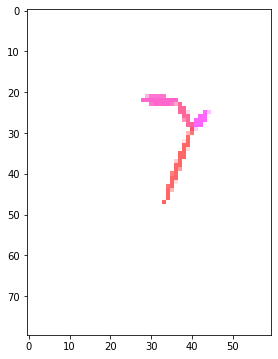

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Input shape: (1, 184, 232, 3)
Output shape (heatmap): (1, 23, 29, 19)
Input shape: (1, 368, 456, 3)
Output shape (heatmap): (1, 46, 57, 19)
Input shape: (1, 552, 680, 3)
Output shape (heatmap): (1, 69, 85, 19)
Input shape: (1, 736, 904, 3)
Output shape (heatmap): (1, 92, 113, 19)
SUBSET LEN BEFORE:  1
SUBSET LEN AFTER:  1
original size:  (288, 352, 3)
resized size viz:  (80, 60, 3)


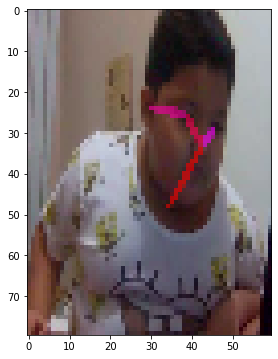

resized size dataset:  (80, 60, 3)


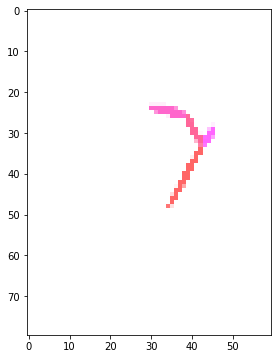

new size:  (80, 60, 3)
Read a new frame:  True
Read a new frame:  True
Read a new frame:  False


In [75]:
import matplotlib
import util

BUFFER_FRAMES = 50

files = os.listdir('RRB_datasets/Processed_Videos/')

files = [
     'normal_64.mp4'
]

for file in files:
    vidcap = cv2.VideoCapture('RRB_datasets/Processed_Videos/' + file)
    
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print('FRAME RATE (FPS): ', fps)
    
    frame_skip_count = 0
    
    success, image = vidcap.read()
    count = 0
    passed_buffer = False
    curr_frame_sequence = []
    while success:   
        success, oriImg = vidcap.read()
        
#         oriImg =  cv2.resize(oriImg, (100, 100))
        
        print('Read a new frame: ', success)
        count += 1
        
        if count < BUFFER_FRAMES and not passed_buffer:
            continue
        elif count >= BUFFER_FRAMES and not passed_buffer:
            passed_buffer = True
            count = 0
            continue
            
        frame_skip_count += 1
        if frame_skip_count != 5:
            continue
        else:
            frame_skip_count = 0

        ###
        ### ---------------------------------------------------------------------------------------
        ###

        param, model_params = config_reader()
        
        try:
            multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
        except:
            print('ERROR!!!!!')
            continue

        heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
        paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

        for m in range(len(multiplier)):
            scale = multiplier[m]
            imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            imageToTest_padded, pad = util.pad_right_down_corner(imageToTest, model_params['stride'], model_params['padValue'])        

            input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
            print("Input shape: " + str(input_img.shape))  

            output_blobs = model.predict(input_img)
            print("Output shape (heatmap): " + str(output_blobs[1].shape))

            # extract outputs, resize, and remove padding
            heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
            heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
            heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
            heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

            paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
            paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
            paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
            paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

            heatmap_avg = heatmap_avg + heatmap / len(multiplier)
            paf_avg = paf_avg + paf / len(multiplier)

        from numpy import ma
        U = paf_avg[:,:,16] * -1
        V = paf_avg[:,:,17]
        X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
        M = np.zeros(U.shape, dtype='bool')
        M[U**2 + V**2 < 0.5 * 0.5] = True
        U = ma.masked_array(U, mask=M)
        V = ma.masked_array(V, mask=M)

        s = 5
        Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
                       scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

        from scipy.ndimage.filters import gaussian_filter
        all_peaks = []
        peak_counter = 0

        for part in range(19-1):
            map_ori = heatmap_avg[:,:,part]
            map = gaussian_filter(map_ori, sigma=3)

            map_left = np.zeros(map.shape)
            map_left[1:,:] = map[:-1,:]
            map_right = np.zeros(map.shape)
            map_right[:-1,:] = map[1:,:]
            map_up = np.zeros(map.shape)
            map_up[:,1:] = map[:,:-1]
            map_down = np.zeros(map.shape)
            map_down[:,:-1] = map[:,1:]

            peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
            peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
            peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
            id = range(peak_counter, peak_counter + len(peaks))
            peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

            all_peaks.append(peaks_with_score_and_id)
            peak_counter += len(peaks)

        # find connection in the specified sequence, center 29 is in the position 15
        limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
                   [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
                   [1,16], [16,18], [3,17], [6,18]]
        # the middle joints heatmap correpondence
        mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
                  [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
                  [55,56], [37,38], [45,46]]

        connection_all = []
        special_k = []
        mid_num = 10

        for k in range(len(mapIdx)):
            score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
            candA = all_peaks[limbSeq[k][0]-1]
            candB = all_peaks[limbSeq[k][1]-1]
            nA = len(candA)
            nB = len(candB)
            indexA, indexB = limbSeq[k]
            if(nA != 0 and nB != 0):
                connection_candidate = []
                for i in range(nA):
                    for j in range(nB):
                        vec = np.subtract(candB[j][:2], candA[i][:2])
                        norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                        # failure case when 2 body parts overlaps
                        if norm == 0:
                            continue
                        vec = np.divide(vec, norm)

                        startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                       np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                        vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                          for I in range(len(startend))])
                        vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                          for I in range(len(startend))])

                        score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                        score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                        criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                        criterion2 = score_with_dist_prior > 0
                        if criterion1 and criterion2:
                            connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

                connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
                connection = np.zeros((0,5))
                for c in range(len(connection_candidate)):
                    i,j,s = connection_candidate[c][0:3]
                    if(i not in connection[:,3] and j not in connection[:,4]):
                        connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                        if(len(connection) >= min(nA, nB)):
                            break

                connection_all.append(connection)
            else:
                special_k.append(k)
                connection_all.append([])


        # last number in each row is the total parts number of that person
        # the second last number in each row is the score of the overall configuration
        subset = -1 * np.ones((0, 20))
        candidate = np.array([item for sublist in all_peaks for item in sublist])

        for k in range(len(mapIdx)):
            if k not in special_k:
                partAs = connection_all[k][:,0]
                partBs = connection_all[k][:,1]
                indexA, indexB = np.array(limbSeq[k]) - 1

                for i in range(len(connection_all[k])): #= 1:size(temp,1)
                    found = 0
                    subset_idx = [-1, -1]
                    for j in range(len(subset)): #1:size(subset,1):
                        if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                            subset_idx[found] = j
                            found += 1

                    if found == 1:
                        j = subset_idx[0]
                        if(subset[j][indexB] != partBs[i]):
                            subset[j][indexB] = partBs[i]
                            subset[j][-1] += 1
                            subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                    elif found == 2: # if found 2 and disjoint, merge them
                        j1, j2 = subset_idx
                        print ("found = 2")
                        membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                        if len(np.nonzero(membership == 2)[0]) == 0: #merge
                            subset[j1][:-2] += (subset[j2][:-2] + 1)
                            subset[j1][-2:] += subset[j2][-2:]
                            subset[j1][-2] += connection_all[k][i][2]
                            subset = np.delete(subset, j2, 0)
                        else: # as like found == 1
                            subset[j1][indexB] = partBs[i]
                            subset[j1][-1] += 1
                            subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                    # if find no partA in the subset, create a new subset
                    elif not found and k < 17:
                        row = -1 * np.ones(20)
                        row[indexA] = partAs[i]
                        row[indexB] = partBs[i]
                        row[-1] = 2
                        row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                        subset = np.vstack([subset, row])
                        
                        
                        
        ###
        ### ---------------------------------------------------------------------------------------
        ###
        
        ###
        ### At this point, the limbs and poses have been detected.
        ### The code below is to fitler out extra limbs, further preprocess, and add the 
        ### resulting image to our dataset.
        ###

        # delete some rows of subset which has few parts occur        
        deleteIdx = [];
        for i in range(len(subset)):
            if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
                deleteIdx.append(i)
        print('SUBSET LEN BEFORE: ', len(subset))
        subset = np.delete(subset, deleteIdx, axis=0)
        print('SUBSET LEN AFTER: ', len(subset))
        
        ###
        ### Discard frame if there is not exactly one stick figure in the frame.
        ###
#         if len(subset) != 1:
#             curr_frame_sequence = []
#             continue

        # visualize
        colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
                  [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
                  [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
        cmap = matplotlib.cm.get_cmap('hsv')

        ###
        ### Canvas with the original image, to use for visualization and quality control.
        ###
        canvas = oriImg # B,G,R order
        
        ###
        ### Blank canvas, to use for making dataset image.
        ###
        canvas_dataset = np.zeros([oriImg.shape[0],oriImg.shape[1],3],dtype=np.uint8)
        canvas_dataset.fill(255)

#         for i in range(18):
#             rgba = np.array(cmap(1 - i/18. - 1./36))
#             rgba[0:3] *= 255
#             for j in range(len(all_peaks[i])):
#                 cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)


        to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)

        stickwidth = 4
        
        ###
        ### Find the person with the largest limb.
        ### We will only draw that person's limbs.
        ###
        n_to_max_length = collections.defaultdict(int)
        for i in range(17):
            for n in range(len(subset)):
                index = subset[n][np.array(limbSeq[i])-1]
                if -1 in index:
                    continue
                Y = candidate[index.astype(int), 0]
                X = candidate[index.astype(int), 1]
                mX = np.mean(X)
                mY = np.mean(Y)
                length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
                if length > n_to_max_length[n]:
                    n_to_max_length[n] = length
                    
        largest_n = -1
        largest_n_val = -1
        for n in n_to_max_length:
            if n_to_max_length[n] > largest_n_val:
                largest_n_val = n_to_max_length[n]
                largest_n = n
        
        ###
        ### Draw the limb for the person with the largest limbs.
        ###
        for i in [ 12, 13, 14, 15, 16 ]: # range(17)
            for n in range(len(subset)):
                
                # Ignore if not the person with the largest limb (largest_n).
                if n != largest_n:
                    continue
                
                index = subset[n][np.array(limbSeq[i])-1]
                if -1 in index:
                    continue
                cur_canvas = canvas.copy()
                cur_canvas_dataset = canvas_dataset.copy()
                Y = candidate[index.astype(int), 0]
                X = candidate[index.astype(int), 1]
                mX = np.mean(X)
                mY = np.mean(Y)
                length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
                angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
                polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
                
                
                ###
                ### NOTE THAT X AND Y ARE REVERSED FOR THE ELLIPSE FUNCTION ABOVE!!!
                ###
                A = int(length/2) * math.sin(math.radians(angle))
                B = math.sqrt(int(length/2)**2 - A**2)
                
                # Draw onto the original image for visualization.
                cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
                canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
                
                # Draw onto the blank canvas to add to the dataset.
                cv2.fillConvexPoly(cur_canvas_dataset, polygon, colors[i])
                canvas_dataset = cv2.addWeighted(canvas_dataset, 0.4, cur_canvas_dataset, 0.6, 0)

                
        ###
        ### ---------------------------------------------------------------------------------------
        ###

        print('original size: ', oriImg.shape)
        
        viz_image_resized = cv2.resize(canvas[:,:,[2,1,0]], (60, 80))
        print('resized size viz: ', viz_image_resized.shape)
        
        plt.rcParams['figure.figsize'] = (6,6)
        
        plt.imshow(viz_image_resized)
        plt.show()
        
        dataset_image_resized = cv2.resize(canvas_dataset[:,:,[2,1,0]], (60, 80))
        print('resized size dataset: ', dataset_image_resized.shape)
        
        plt.imshow(dataset_image_resized)
        plt.show()
        
        print('new size: ', dataset_image_resized.shape)
        
        curr_frame_sequence.append(dataset_image_resized)
        
        if len(curr_frame_sequence) == NUM_FRAMES_PER_FRAME_SEQUENCE:
            if 'armflapping_hand' in file:
                armflapping_hand_sequences.append(curr_frame_sequence)
            if 'headbanging_head' in file:
                headbanging_head_sequences.append(curr_frame_sequence)
            if 'normal' in file:
                normal_sequences.append(curr_frame_sequence)
            if 'spinning_body' in file:
                spinning_body_sequences.append(curr_frame_sequence)
            if 'spinning_head' in file:
                spinning_head_sequences.append(curr_frame_sequence)
                
            curr_frame_sequence = []
        
        


In [49]:
len(headbanging_head_sequences), len(normal_sequences)

(0, 6)

In [ ]:
# headbanging_head_sequences = headbanging_head_sequences[:-1]

In [ ]:
'''
FINISHED FILES

HEADBANGING: 

headbanging_head_14.mp4 (part 1) - A
headbanging_head_14.mp4 (part 2) - A
headbanging_head_15.mp4 (part 3) - B
headbanging_head_19.mp4 (part 4) - C
headbanging_head_2.mp4 (part 5) - D
headbanging_head_21.mp4 (part 6) - E
headbanging_head_22.mp4 (part 7) - F
headbanging_head_23.mp4 (part 8) - F
headbanging_head_24.mp4 (part 9) - F
headbanging_head_30.mp4 (part 10) - G

NOT HEADBANGING:

normal_0.mp4 (part 1) - A
normal_35.mp4 (part 2) - B
normal_22.mp4 (part 3) - C
normal_62.mp4 (part 4) - D
normal_64.mp4 (part 5) - D
normal_113.mp4 (part 6) - E
normal_61.mp4 (part 7) - D

'''

In [5]:
curr_file = 'saved_keypoint_images/headbanging_head_sequences_part' + str(1) + '.npy'
seq = np.load(curr_file)
len(seq), seq

NameError: name 'np' is not defined

# (MAYBE) Save sequences to file.

In [50]:
# np.save('saved_keypoint_images/headbanging_head_sequences_part10.npy', headbanging_head_sequences) 
np.save('saved_keypoint_images/normal_sequences_part7.npy', normal_sequences) 

# Load sequenes from file.

In [7]:
NUM_HEADBANGING_SEQUENCES = 10
NUM_NORMAL_SEQUENCES = 7

headbanging_head_sequences_in_train = [[], [], [], [], []] 
normal_sequences_in_train = [[], [], [], [], []] 

headbanging_head_sequences_in_test = [[], [], [], [], []] 
normal_sequences_in_test = [[], [], [], [], []] 

test_indices_headbanging = [
    [1,2,3,4],
    [5,6],
    [7,8,9],
]

test_indices_normal = [
    [4,5,7],
    [1,3],
    [2],
]

for fold in range(len(test_indices_headbanging)):
    
    for i in range(1, NUM_HEADBANGING_SEQUENCES + 1):
        curr_file = 'saved_keypoint_images/headbanging_head_sequences_part' + str(i) + '.npy'
        headbanging_head_sequences_in_next = np.load(curr_file)
        if i in test_indices_headbanging[fold]:
            headbanging_head_sequences_in_test[fold] += list(headbanging_head_sequences_in_next)
        else:
            headbanging_head_sequences_in_train[fold] += list(headbanging_head_sequences_in_next)
        print('fold: ', fold)
        print('len: ', len(list(headbanging_head_sequences_in_next)))
        print('single thing in list: ', list(headbanging_head_sequences_in_next)[0].shape)
        print('size of test array: ', len( headbanging_head_sequences_in_test[fold]))
        print('size of train array: ', len( headbanging_head_sequences_in_train[fold]))
        print()

    for i in range(1, NUM_NORMAL_SEQUENCES + 1):
        curr_file = 'saved_keypoint_images/normal_sequences_part' + str(i) + '.npy'
        normal_sequences_in_next = np.load(curr_file)
        if i in test_indices_normal[fold]:
            normal_sequences_in_test[fold] += list(normal_sequences_in_next)
        else:
            normal_sequences_in_train[fold] += list(normal_sequences_in_next)

fold:  0
len:  3
single thing in list:  (6, 80, 60, 3)
size of test array:  3
size of train array:  0

fold:  0
len:  1
single thing in list:  (6, 80, 60, 3)
size of test array:  4
size of train array:  0

fold:  0
len:  2
single thing in list:  (6, 80, 60, 3)
size of test array:  6
size of train array:  0

fold:  0
len:  11
single thing in list:  (6, 80, 60, 3)
size of test array:  17
size of train array:  0

fold:  0
len:  9
single thing in list:  (6, 80, 60, 3)
size of test array:  17
size of train array:  9

fold:  0
len:  8
single thing in list:  (6, 80, 60, 3)
size of test array:  17
size of train array:  17

fold:  0
len:  5
single thing in list:  (6, 80, 60, 3)
size of test array:  17
size of train array:  22

fold:  0
len:  6
single thing in list:  (6, 80, 60, 3)
size of test array:  17
size of train array:  28

fold:  0
len:  4
single thing in list:  (6, 80, 60, 3)
size of test array:  17
size of train array:  32

fold:  0
len:  5
single thing in list:  (6, 80, 60, 3)
size of

In [9]:
for fold in range(len(test_indices_headbanging)):
    print('fold: ', fold)
    print('size of test array: ', len( headbanging_head_sequences_in_test[fold]))
    print('size of train array: ', len( headbanging_head_sequences_in_train[fold]))
    print()
    print()

fold:  0
size of test array:  17
size of train array:  37


fold:  1
size of test array:  17
size of train array:  37


fold:  2
size of test array:  15
size of train array:  39




In [11]:
for fold in range(len(test_indices_normal)):
    print('fold: ', fold)
    print('size of test array: ', len( normal_sequences_in_test[fold]))
    print('size of train array: ', len( normal_sequences_in_train[fold]))
    print()
    print()

fold:  0
size of test array:  11
size of train array:  43


fold:  1
size of test array:  13
size of train array:  41


fold:  2
size of test array:  20
size of train array:  34




In [78]:
54 / 3, 54 - 54 / 3

(18.0, 36.0)

In [79]:
###
### Gather data.
###

X_train_L_pre = [[], [], [], [], []] 
y_train_L_pre = [[], [], [], [], []] 

X_test_L_pre = [[], [], [], [], []] 
y_test_L_pre = [[], [], [], [], []] 

# -------------

    
for fold in range(len(train_test_indices_headbanging)):
    
    for i in range(len(headbanging_head_sequences_in_train[fold])):
        sequence = headbanging_head_sequences_in_train[fold][i]
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_train_L_pre[fold].append(resized_sequence)
        y_train_L_pre[fold].append('headbanging_head')

    for i in range(len(headbanging_head_sequences_in_test[fold])):
        sequence = headbanging_head_sequences_in_test[fold][i]
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_test_L_pre[fold].append(resized_sequence)
        y_test_L_pre[fold].append('headbanging_head')

    
# -------------
    
for fold in range(len(train_test_indices_normal)):
    
    for i in range(len(normal_sequences_in_train[fold])):
        sequence = normal_sequences_in_train[fold][i]
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_train_L_pre[fold].append(resized_sequence)
        y_train_L_pre[fold].append('normal')

    for i in range(len(normal_sequences_in_test[fold])):
        sequence = normal_sequences_in_test[fold][i]
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_test_L_pre[fold].append(resized_sequence)
        y_test_L_pre[fold].append('normal')
    

# ---

# OPTION 2: UNMODIFIED REPRESENTATION

# ---

# Create frame sequences for the raw input videos (not human poses) instead of extracting features.

In [20]:
armflapping_hand_sequences_train = []
headbanging_head_sequences_train = []
normal_sequences_train = []
spinning_body_sequences_train = []
spinning_head_sequences_train = []

armflapping_hand_sequences_test = []
headbanging_head_sequences_test = []
normal_sequences_test = []
spinning_body_sequences_test = []
spinning_head_sequences_test = []

In [21]:
files = os.listdir('RRB_datasets/Processed_Videos/')

files = [
     'armflapping_hand_23.mp4'
]

behavior_to_file_count = collections.defaultdict(int)

TRAINING_SEQUENCES = 300
TESTING_SEQUENCES = 25

for file in files:
    print('FILE: ', file)
    vidcap = cv2.VideoCapture('RRB_datasets/Processed_Videos/' + file)
    success, image = vidcap.read()
    count = 0
    curr_frame_sequence = []
    
    while success:   
        success, oriImg = vidcap.read()
        
        curr_frame_sequence.append(oriImg)
        
        if len(curr_frame_sequence) == NUM_FRAMES_PER_FRAME_SEQUENCE:
#             if 'armflapping_hand' in file:
#                 behavior_to_file_count['armflapping_hand'] += 1
#                 armflapping_hand_sequences.append(curr_frame_sequence)
            if 'headbanging_head' in file:
                behavior_to_file_count['headbanging_head'] += 1
                if behavior_to_file_count['headbanging_head'] <= TRAINING_SEQUENCES:
                    headbanging_head_sequences_train.append(curr_frame_sequence)
                elif behavior_to_file_count['headbanging_head'] <= TRAINING_SEQUENCES + TESTING_SEQUENCES:
                    headbanging_head_sequences_test.append(curr_frame_sequence)
            if 'normal' in file:
                behavior_to_file_count['normal'] += 1
                if behavior_to_file_count['normal'] <= TRAINING_SEQUENCES:
                    normal_sequences_train.append(curr_frame_sequence)
                elif behavior_to_file_count['normal'] <= TRAINING_SEQUENCES + TESTING_SEQUENCES:
                    normal_sequences_test.append(curr_frame_sequence)
            if 'spinning_body' in file:
                behavior_to_file_count['spinning_body'] += 1
                if behavior_to_file_count['spinning_body'] <= TRAINING_SEQUENCES:
                    spinning_body_sequences_train.append(curr_frame_sequence)
                elif behavior_to_file_count['spinning_body'] <= TRAINING_SEQUENCES + TESTING_SEQUENCES:
                    spinning_body_sequences_test.append(curr_frame_sequence)
            if 'spinning_head' in file:
                behavior_to_file_count['spinning_head'] += 1
                if behavior_to_file_count['spinning_head'] <= TRAINING_SEQUENCES:
                    spinning_head_sequences_train.append(curr_frame_sequence)
                elif behavior_to_file_count['spinning_head'] <= TRAINING_SEQUENCES + TESTING_SEQUENCES:
                    spinning_head_sequences_test.append(curr_frame_sequence)

            curr_frame_sequence = []
            
            print('Added new frame sequence')

FILE:  armflapping_hand_23.mp4
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence
Added new frame sequence


In [ ]:
#len(armflapping_hand_sequences), len(headbanging_head_sequences), len(normal_sequences),len(spinning_body_sequences), len(spinning_head_sequences)

In [ ]:
behavior_to_file_count

In [ ]:
X_train_L_pre = []
y_train_L_pre = []

X_test_L_pre = []
y_test_L_pre = []

# -------------

# for sequence in armflapping_hand_sequences_train:
#     resized_sequence = []
#     for img in sequence:
#         resized_img = cv2.resize(img, (80, 60))
#         resized_sequence.append(resized_img)
#     X_train_L_pre.append(resized_sequence)
#     y_train_L_pre.append('armflapping_hand')
    
# for sequencec in armflapping_hand_sequences_test:
#     resized_sequence = []
#     for img in sequence:
#         resized_img = cv2.resize(img, (80, 60))
#         resized_sequence.append(resized_img)
#     X_test_L_pre.append(resized_sequence)
#     y_test_L_pre.append('armflapping_hand')
    
# -------------
    
for sequence in headbanging_head_sequences_train:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_train_L_pre.append(resized_sequence)
        y_train_L_pre.append('headbanging_head')
    except:
        print('error1')
        continue

for sequence in headbanging_head_sequences_test:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_test_L_pre.append(resized_sequence)
        y_test_L_pre.append('headbanging_head')
    except:
        print('error2')
        continue

    
# -------------
    
for sequence in normal_sequences_train:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_train_L_pre.append(resized_sequence)
        y_train_L_pre.append('normal')
    except:
        print('error3')
        continue
    
for sequence in normal_sequences_test:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_test_L_pre.append(resized_sequence)
        y_test_L_pre.append('normal')
    except:
        print('error4')
        continue
    
# -------------
    
for sequence in spinning_body_sequences_train:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_train_L_pre.append(resized_sequence)
        y_train_L_pre.append('spinning_body')
    except:
        print('error5')
        continue
    
for sequence in spinning_body_sequences_test:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_test_L_pre.append(resized_sequence)
        y_test_L_pre.append('spinning_body')
    except:
        print('error6')
        continue
    
# -------------
    
for sequence in spinning_head_sequences_train:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_train_L_pre.append(resized_sequence)
        y_train_L_pre.append('spinning_head')
    except:
        print('error7')
        continue
    
for sequence in spinning_head_sequences_test:
    try:
        resized_sequence = []
        for img in sequence:
            resized_img = cv2.resize(img, (80, 60))
            resized_sequence.append(resized_img)
        X_test_L_pre.append(resized_sequence)
        y_test_L_pre.append('spinning_head')
    except:
        print('error8')
        continue

# ---

# OPTION 3: LUCAS-KANADE OPTICAL FLOW REPRESENTATION

# ---

FILE:  headbanging_head_24.mp4
read next frame
(325, 2) (325, 2)
read next frame
(306, 2) (306, 2)
read next frame
(298, 2) (298, 2)
read next frame
(297, 2) (297, 2)
read next frame
(296, 2) (296, 2)
read next frame
(296, 2) (296, 2)


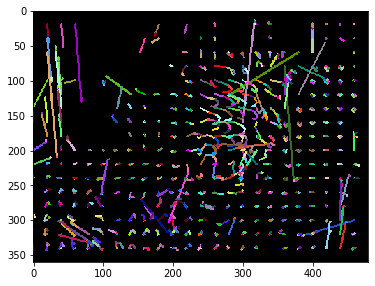

read next frame
(296, 2) (296, 2)
read next frame
(294, 2) (294, 2)
read next frame
(293, 2) (293, 2)
read next frame
(293, 2) (293, 2)
read next frame
(293, 2) (293, 2)


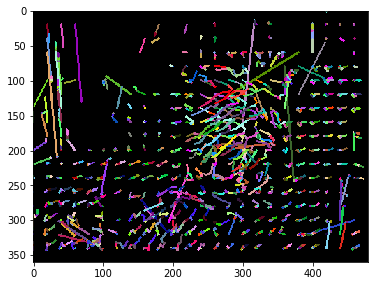

read next frame
(293, 2) (293, 2)
read next frame
(293, 2) (293, 2)
read next frame
(293, 2) (293, 2)
read next frame
(293, 2) (293, 2)
read next frame
(292, 2) (292, 2)


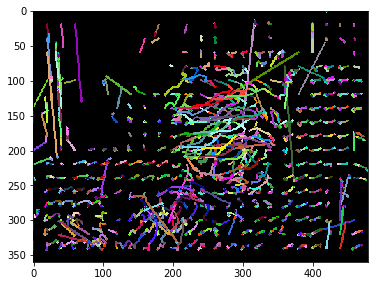

read next frame
(291, 2) (291, 2)
read next frame
(291, 2) (291, 2)
read next frame
(290, 2) (290, 2)
read next frame
(290, 2) (290, 2)
read next frame
(289, 2) (289, 2)


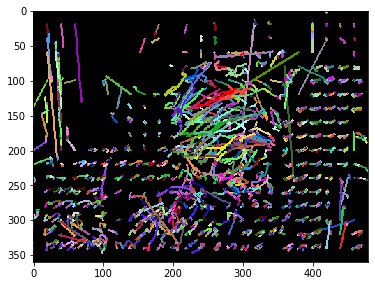

read next frame
(289, 2) (289, 2)
read next frame
(288, 2) (288, 2)
read next frame
(288, 2) (288, 2)
read next frame
(288, 2) (288, 2)
read next frame
(287, 2) (287, 2)


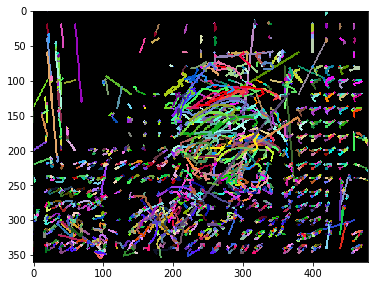

read next frame
(282, 2) (282, 2)
read next frame
(282, 2) (282, 2)
read next frame
(281, 2) (281, 2)
read next frame
(281, 2) (281, 2)
read next frame
(278, 2) (278, 2)


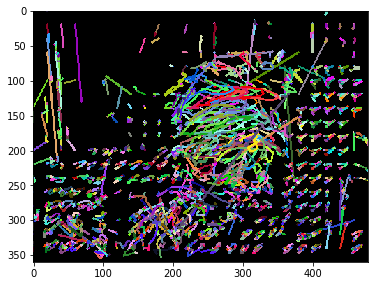

read next frame
(278, 2) (278, 2)
read next frame
(277, 2) (277, 2)
read next frame
(277, 2) (277, 2)
read next frame
(276, 2) (276, 2)
read next frame
(276, 2) (276, 2)


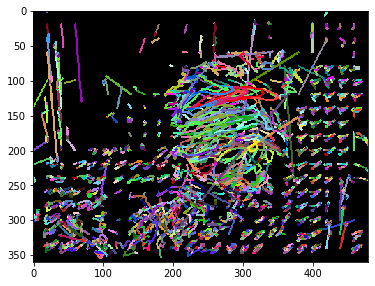

read next frame
(276, 2) (276, 2)
read next frame
(276, 2) (276, 2)
read next frame
(275, 2) (275, 2)
read next frame
(275, 2) (275, 2)
read next frame
(274, 2) (274, 2)


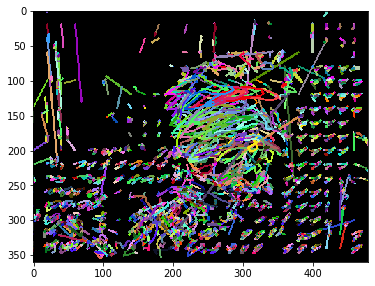

read next frame
(274, 2) (274, 2)
read next frame
(273, 2) (273, 2)
read next frame
(272, 2) (272, 2)
read next frame
(269, 2) (269, 2)
read next frame
(269, 2) (269, 2)


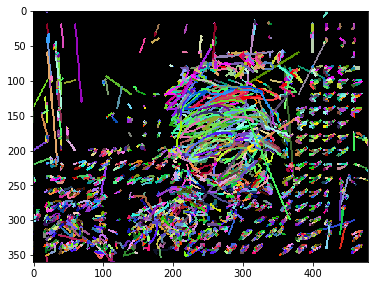

read next frame
(268, 2) (268, 2)
read next frame
(268, 2) (268, 2)
read next frame
(268, 2) (268, 2)
read next frame
(268, 2) (268, 2)
read next frame
(268, 2) (268, 2)


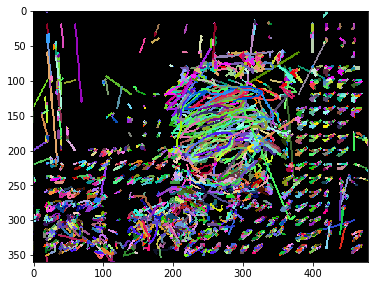

read next frame
(268, 2) (268, 2)
read next frame
(268, 2) (268, 2)
read next frame
(266, 2) (266, 2)
read next frame
(266, 2) (266, 2)
read next frame
(266, 2) (266, 2)


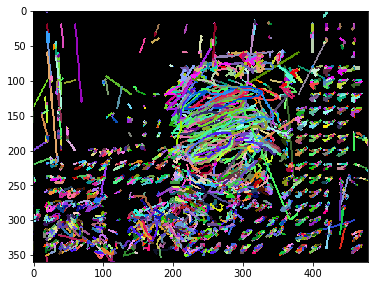

read next frame
(266, 2) (266, 2)
read next frame
(266, 2) (266, 2)
read next frame
(266, 2) (266, 2)
read next frame
(266, 2) (266, 2)
read next frame
(266, 2) (266, 2)


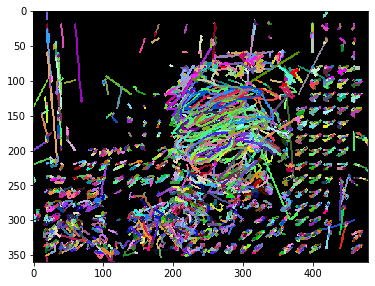

read next frame
(264, 2) (264, 2)
read next frame
(264, 2) (264, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)


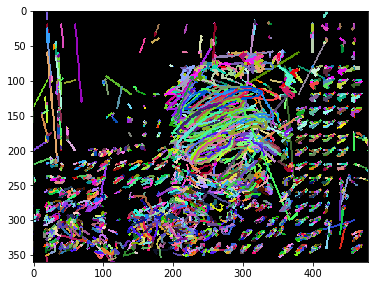

read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)


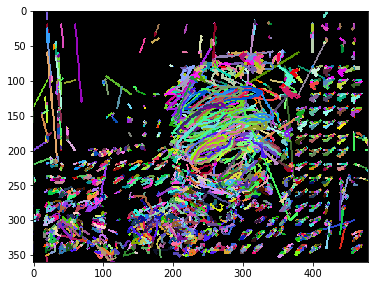

read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)


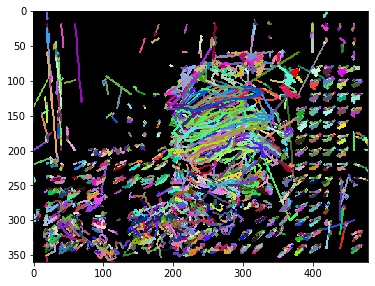

read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)


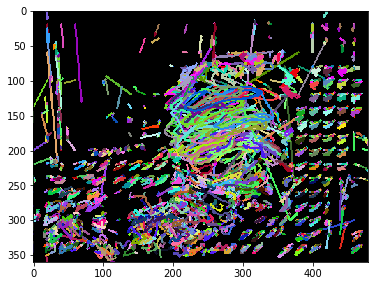

read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)
read next frame
(263, 2) (263, 2)


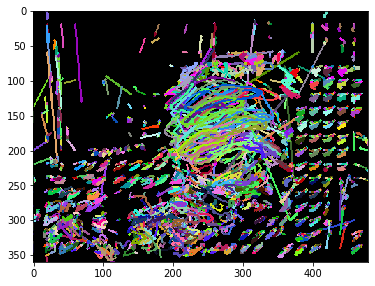

read next frame
(262, 2) (262, 2)
read next frame
(261, 2) (261, 2)
read next frame
(261, 2) (261, 2)
read next frame
(261, 2) (261, 2)
read next frame
(261, 2) (261, 2)


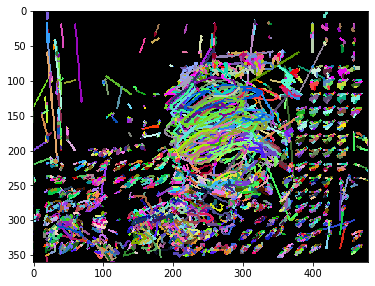

read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)


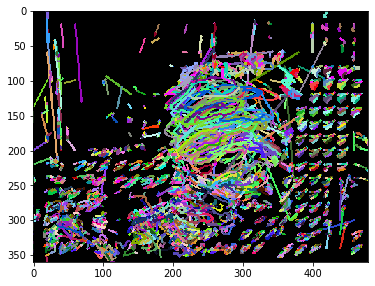

read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)


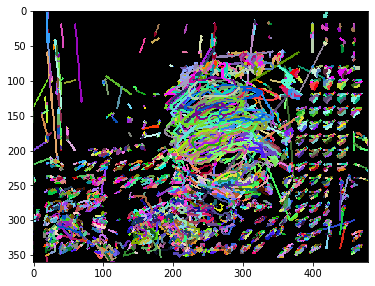

read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)
read next frame
(260, 2) (260, 2)


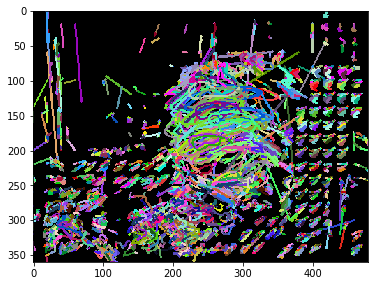

read next frame
(260, 2) (260, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


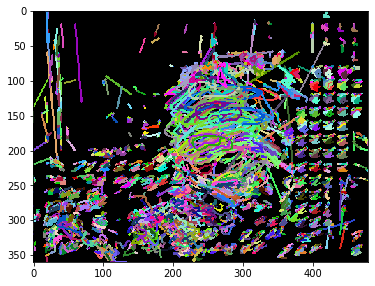

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


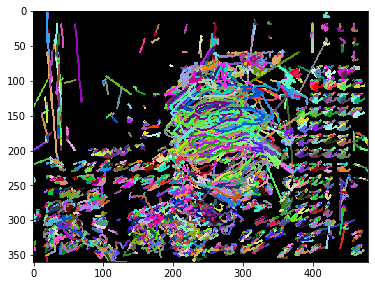

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


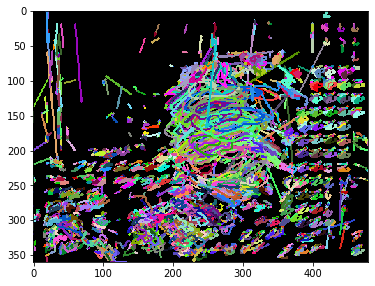

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


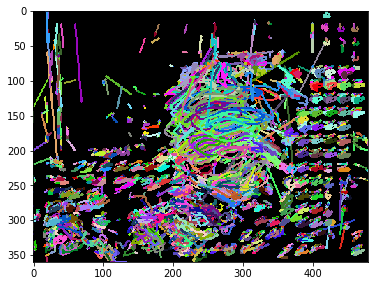

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


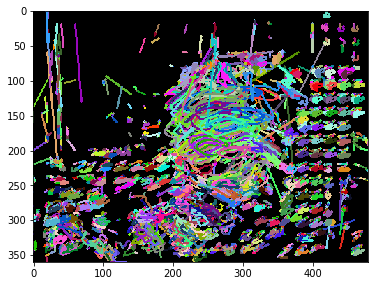

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


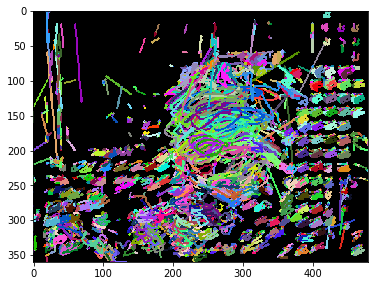

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


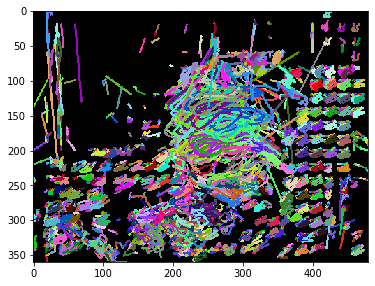

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


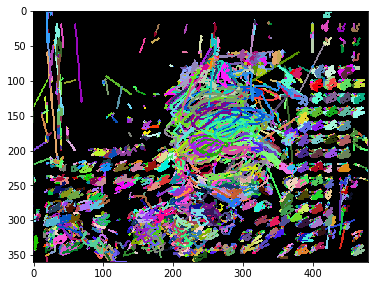

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


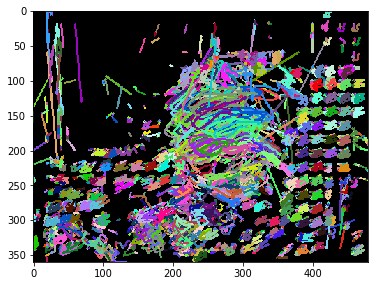

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


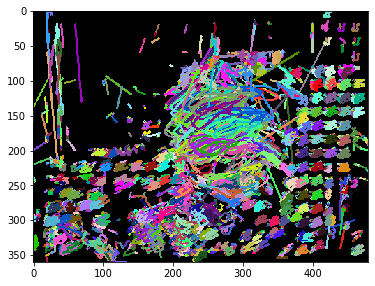

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


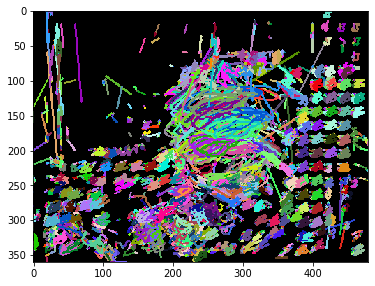

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


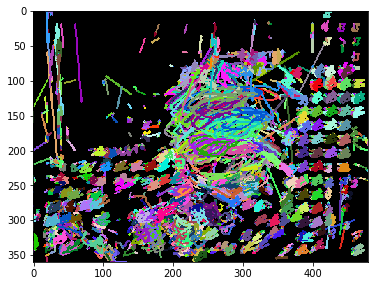

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


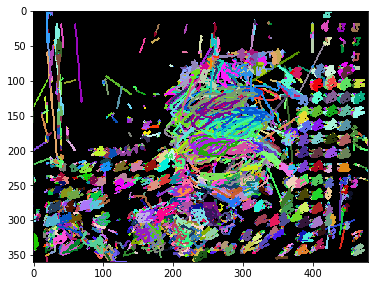

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


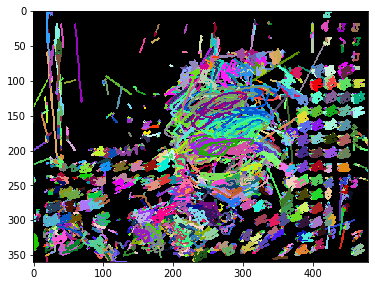

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


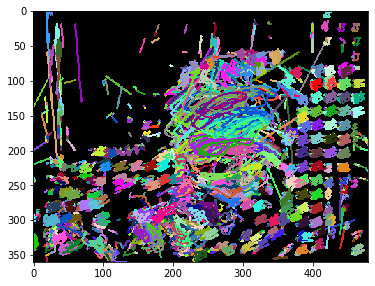

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


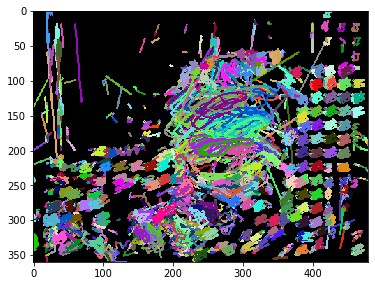

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


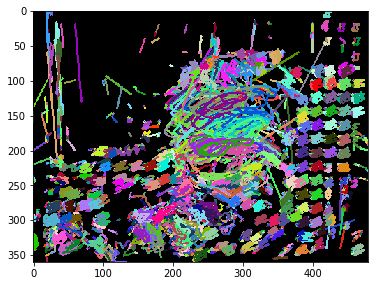

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


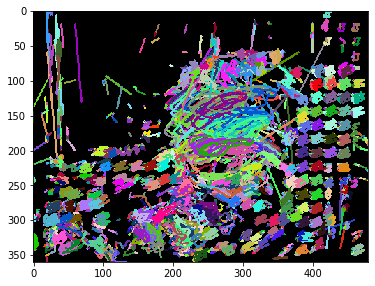

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)


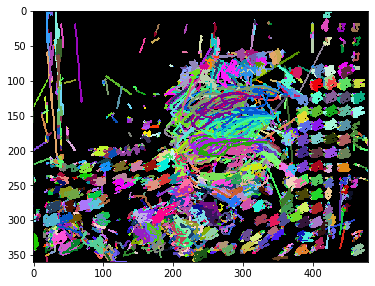

read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(257, 2) (257, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


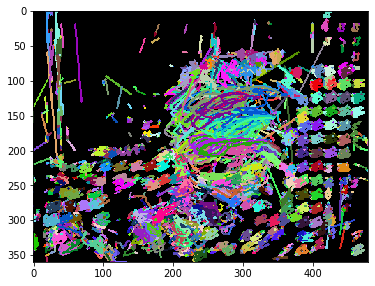

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


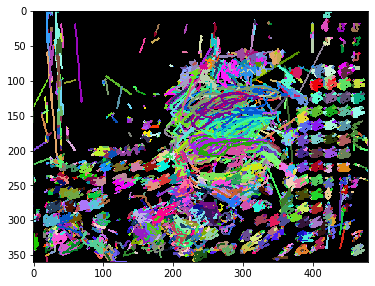

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


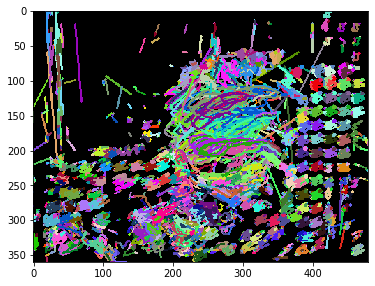

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


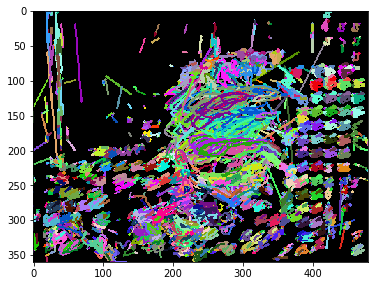

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


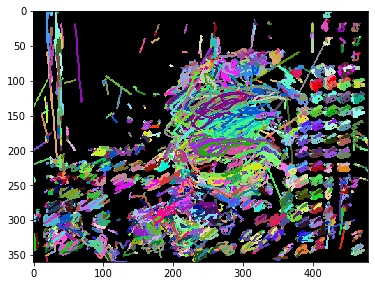

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


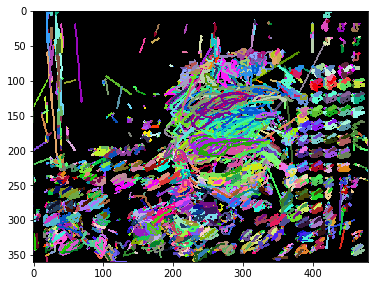

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


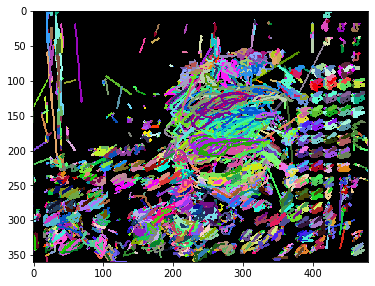

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


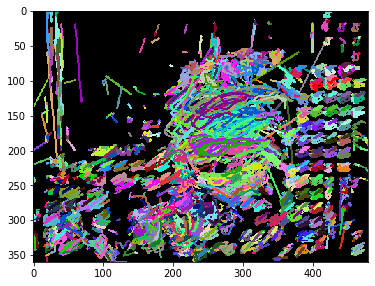

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


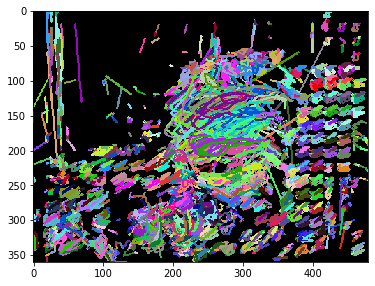

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


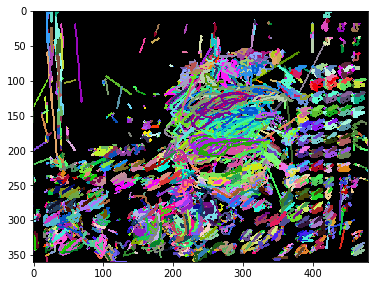

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


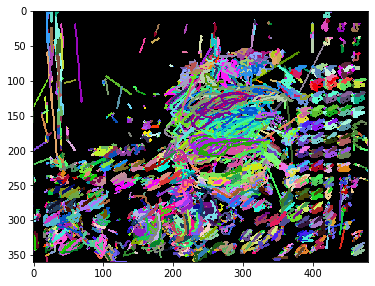

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


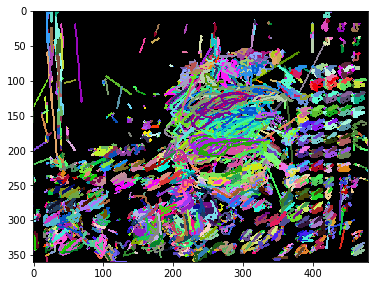

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


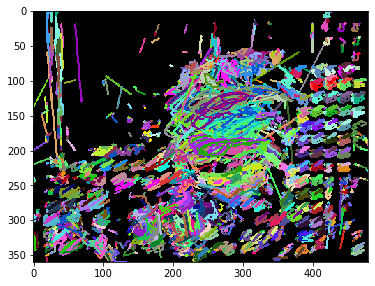

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


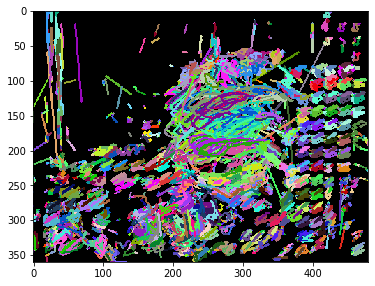

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


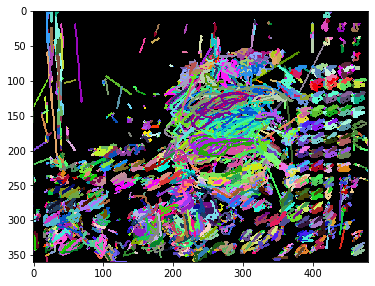

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


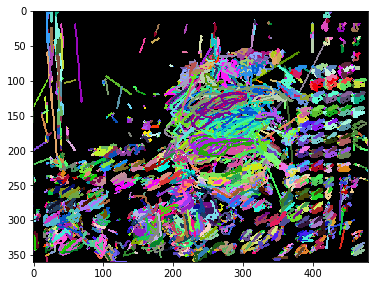

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


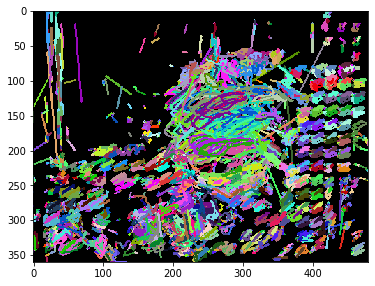

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


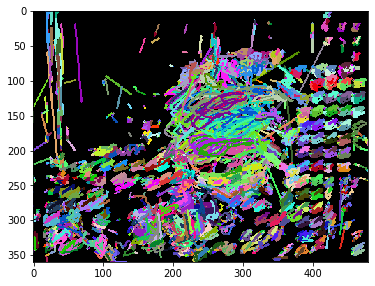

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


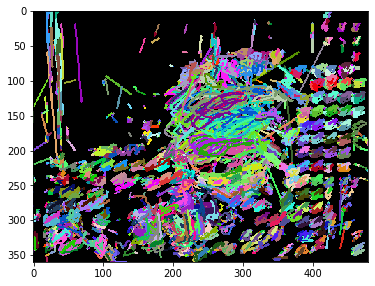

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


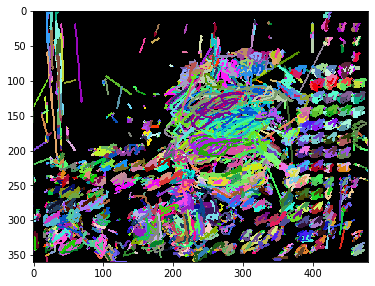

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


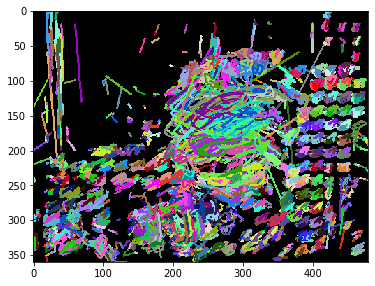

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)


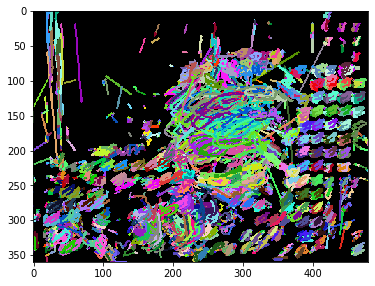

read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(256, 2) (256, 2)
read next frame
(255, 2) (255, 2)


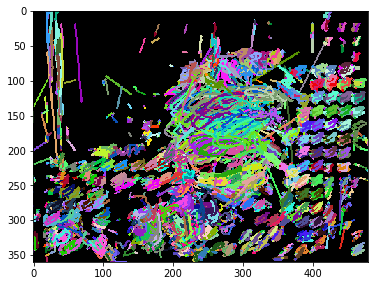

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


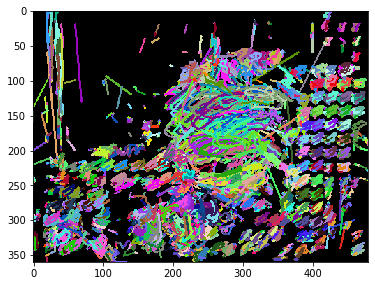

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


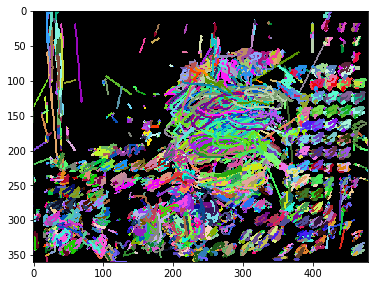

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


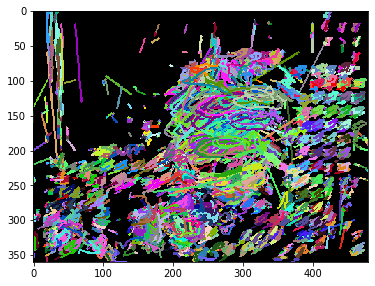

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


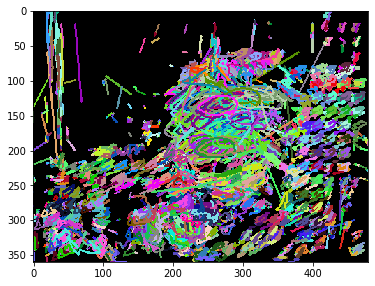

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


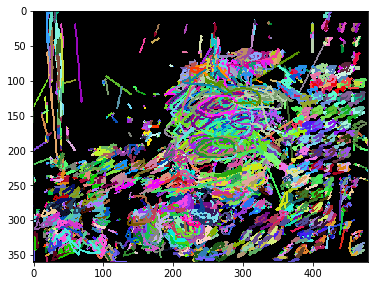

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


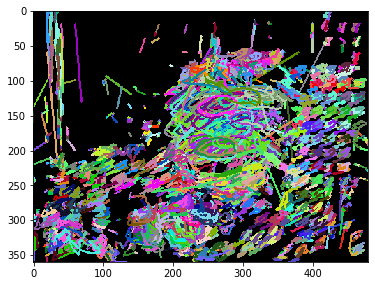

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


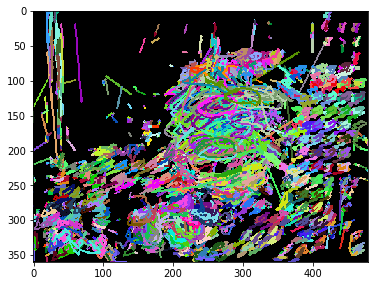

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)


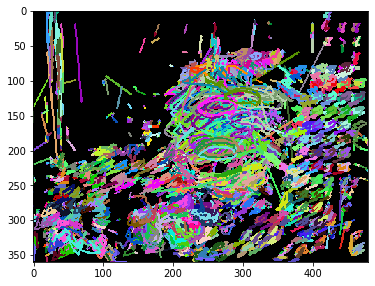

read next frame
(255, 2) (255, 2)
read next frame
(255, 2) (255, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)


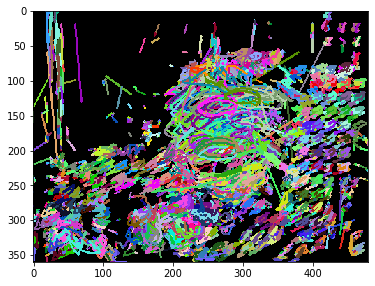

read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)


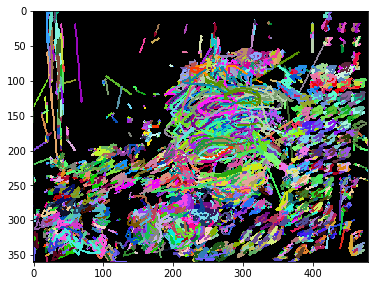

read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)


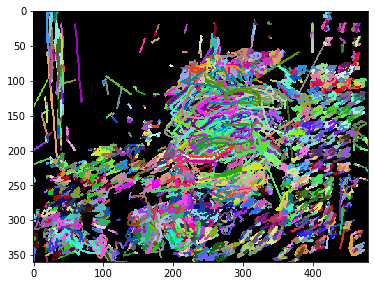

read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)
read next frame
(254, 2) (254, 2)


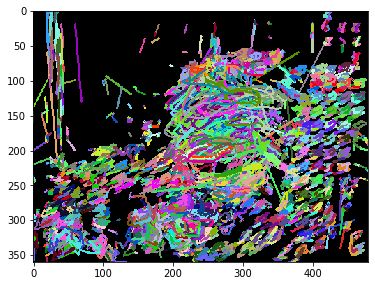

read next frame
(254, 2) (254, 2)
read next frame
(253, 2) (253, 2)
read next frame
(253, 2) (253, 2)
read next frame
(253, 2) (253, 2)
read next frame
(253, 2) (253, 2)


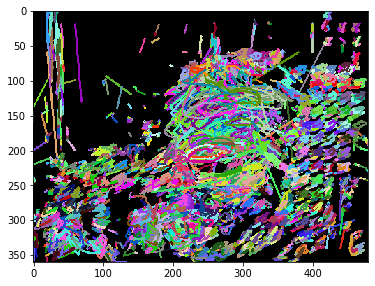

read next frame
(253, 2) (253, 2)
read next frame
(253, 2) (253, 2)
read next frame
(253, 2) (253, 2)
read next frame
(252, 2) (252, 2)
read next frame
(252, 2) (252, 2)


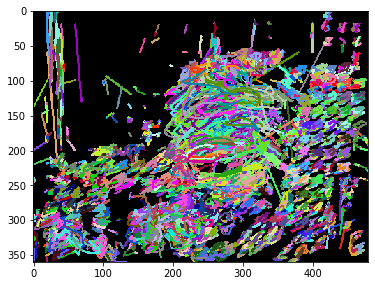

read next frame
(252, 2) (252, 2)
read next frame
(252, 2) (252, 2)
read next frame
(252, 2) (252, 2)
read next frame
(252, 2) (252, 2)
read next frame
(251, 2) (251, 2)


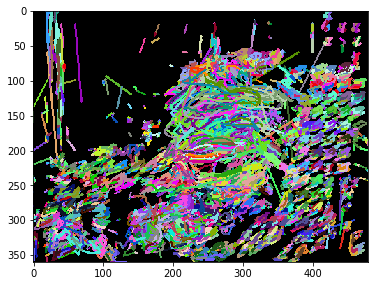

read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)


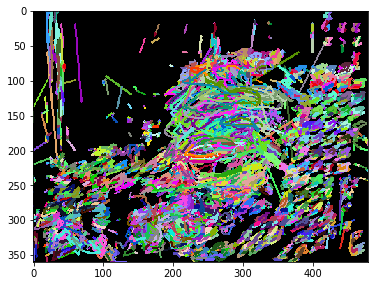

read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)


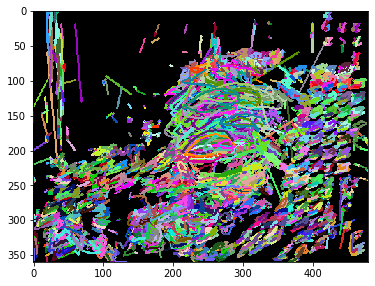

read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)


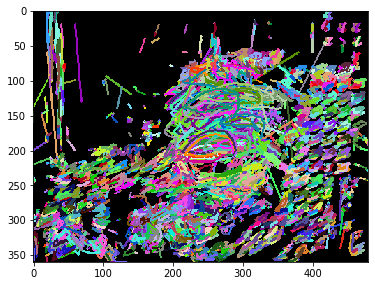

read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)


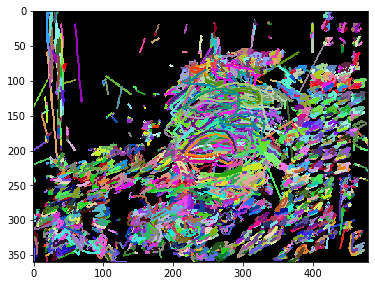

read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)


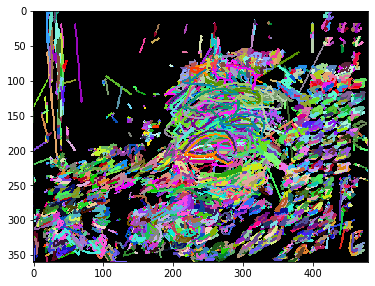

read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame
(251, 2) (251, 2)
read next frame


AttributeError: 'NoneType' object has no attribute 'fill'

In [64]:
import copy

files = os.listdir('RRB_datasets/Processed_Videos/')

files = [
     'headbanging_head_24.mp4'
]

BUFFER_FRAMES = 0
plt.rcParams['figure.figsize'] = (6,6)


MAX_TRACKING_POINTS = 100000

for file in files:
    print('FILE: ', file)
    
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = MAX_TRACKING_POINTS,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors
    color = np.random.randint(0, 255, (MAX_TRACKING_POINTS, 3))

    vidcap = cv2.VideoCapture('RRB_datasets/Processed_Videos/' + file)
    ret, old_frame = vidcap.read()
    
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    #p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    # Use a uniform grid of tracking points.
    p0 = []
    for i in range(0, old_gray.shape[0], 20):
        for j in range(0, old_gray.shape[1], 20):
            a = np.array([np.array([j,i], dtype=np.float32)], dtype=np.float32)
            p0.append(a)
    p0 = np.array(p0)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    mask_white = np.zeros_like(old_frame)
    
    count = 0
    curr_frame_sequence = []
    
    
    frame_skip_count = 0
    passed_buffer = False
    
    
    while ret:   
        print('read next frame')
        ret, frame = vidcap.read()
        og_img = copy.deepcopy(frame)
        
        canvas_blank = copy.deepcopy(frame)
        canvas_blank.fill(255)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        og_img = cv2.cvtColor(og_img, cv2.COLOR_RGB2BGR)
        canvas_blank = cv2.cvtColor(canvas_blank, cv2.COLOR_RGB2BGR)
        
        
        try:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        except:
            continue

        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        
        print(good_new.shape, good_old.shape)

        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)

            frame = cv2.circle(frame, (a,b), 1, color[i].tolist(), -1)
            canvas_blank = cv2.circle(canvas_blank, (a,b), 1, color[i].tolist(), -1)
            
        img = cv2.add(frame, mask)
        img_white = cv2.add(canvas_blank, mask)
        
        
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)

        count += 1
        if count < BUFFER_FRAMES and not passed_buffer:
            continue
        elif count >= BUFFER_FRAMES and not passed_buffer:
            passed_buffer = True
            count = 0
            continue
            
        frame_skip_count += 1
        if frame_skip_count != 5:
            continue
        else:
            frame_skip_count = 0
            
        plt.imshow(mask)
        plt.show()
            
#         plt.imshow(img)
#         plt.show()
        
#         plt.imshow(img_white)
#         plt.show()

#         plt.imshow(og_img)
#         plt.show()

# ---

# OPTION 4: DENSE OPTICAL FLOW REPRESENTATION

# ---

FILE:  headbanging_head_24.mp4


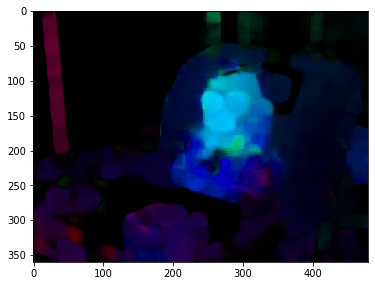

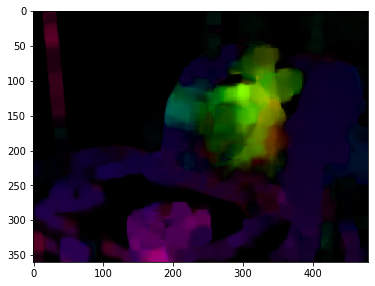

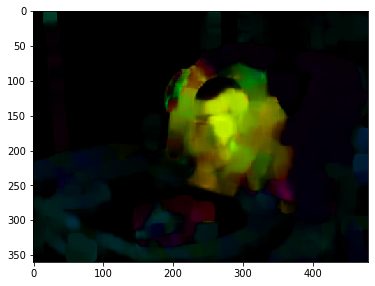

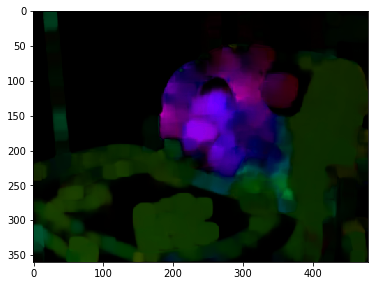

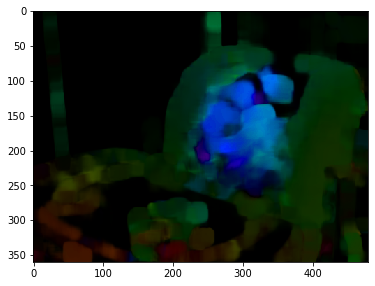

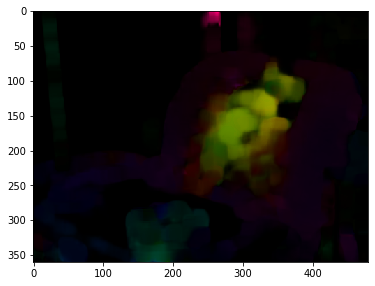

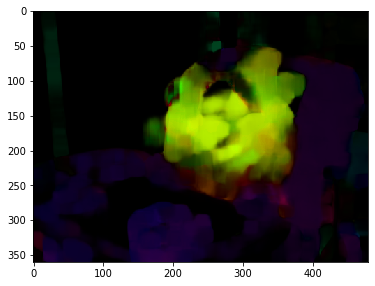

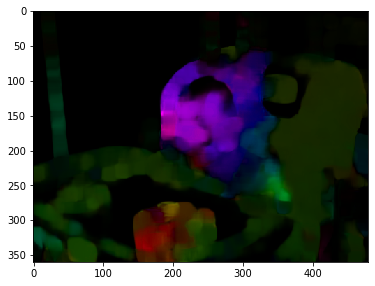

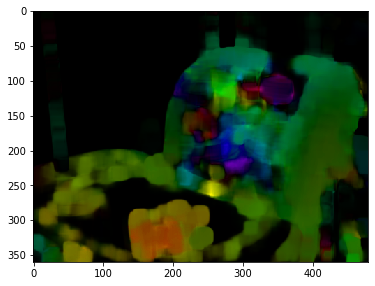

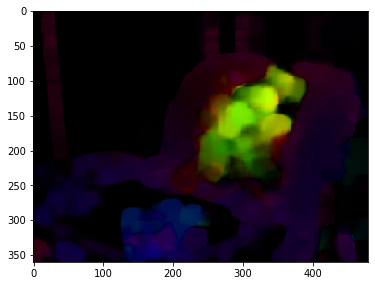

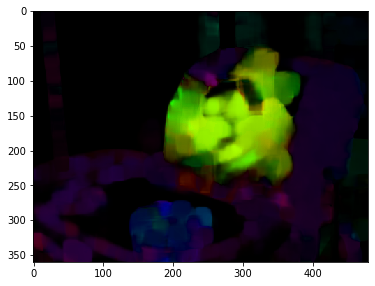

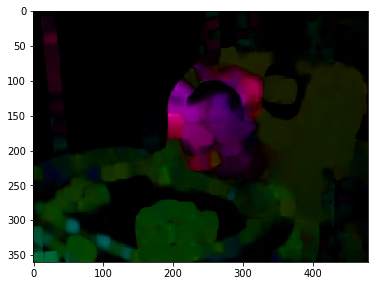

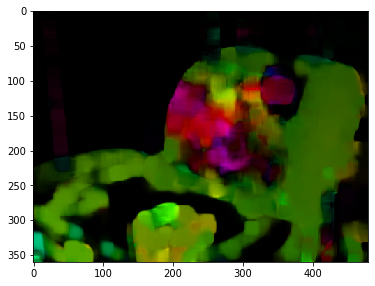

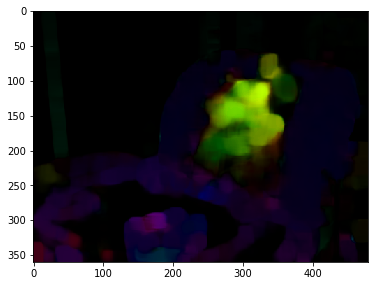

KeyboardInterrupt: 

In [45]:
# files = os.listdir('RRB_datasets/Processed_Videos/')

files = [
     'headbanging_head_24.mp4'
]

BUFFER_FRAMES = 0
plt.rcParams['figure.figsize'] = (6,6)

for file in files:
    print('FILE: ', file)

    vidcap = cv2.VideoCapture('RRB_datasets/Processed_Videos/' + file)
    ret, frame1 = vidcap.read()
    
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    
    count = 0
    
    frame_skip_count = 0
    passed_buffer = False
    
    while ret:   
        ret, frame2 = vidcap.read()
        
        nxt = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

        count += 1
        if count < BUFFER_FRAMES and not passed_buffer:
            continue
        elif count >= BUFFER_FRAMES and not passed_buffer:
            passed_buffer = True
            count = 0
            continue
            
        frame_skip_count += 1
        if frame_skip_count != 5:
            continue
        else:
            frame_skip_count = 0
            

        plt.imshow(rgb)
        plt.show()

        prvs = nxt
        

# Helper functions.

In [80]:
from keras import backend as K
from scipy.ndimage import zoom

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision




# Get classifier situation going on.

In [81]:
###
### Use all GPUs.
###
strategy = tf.distribute.MirroredStrategy()
print()
print()
print()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)



Number of devices: 1


In [85]:
###
### Train model using ALL GPUs with 5-fold cross validation.
###

import random
from scipy import ndimage, misc

with strategy.scope():
    
    
    for fold in range(3):
        
        
        ###
        ### Convert data from correct fold.
        ###

        X_train_L = np.array(X_train_L_pre[fold]).astype('uint8')
        y_train_L = np.array(y_train_L_pre[fold])
        
        print('Dataset shape:', X_train_L.shape, y_train_L.shape)

        encoder = LabelBinarizer()
        y_train_L = encoder.fit_transform(y_train_L)

        # -------------

        X_test_L = np.array(X_test_L_pre[fold]).astype('uint8')
        y_test_L = np.array(y_test_L_pre[fold])

        encoder = LabelBinarizer()
        y_test_L = encoder.fit_transform(y_test_L)
        
        # -------------
        
        class_to_count_test = collections.defaultdict(int)
        for a in y_test_L_pre[fold]:
            class_to_count_test[a] += 1
        print('Test: ', class_to_count_test)

        class_to_count_train = collections.defaultdict(int)
        for a in y_train_L_pre[fold]:
            class_to_count_train[a] += 1
        print('Train: ', class_to_count_train)
        
        
        ###
        ### Specify model architecture.
        ###

        def build_convnet(shape=None):
            momentum = 0.9
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=shape[1:], padding='same', activation='linear'))
            model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
            model.add(tf.keras.layers.Activation('relu'))

            model.add(tf.keras.layers.MaxPool2D())

            model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='linear'))
            model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
            model.add(tf.keras.layers.Activation('relu'))

            model.add(tf.keras.layers.MaxPool2D())

            model.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='linear'))
            model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
            model.add(tf.keras.layers.Activation('relu'))

            # flatten
            model.add(tf.keras.layers.GlobalMaxPool2D())
            return model

        shape = X_train_L.shape[1:]
        print('Train data shape: ', shape)

        convnet = build_convnet(shape)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.TimeDistributed(convnet, input_shape=shape))
        model.add(tf.keras.layers.LSTM(64))

        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dropout(.5))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(.5))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dropout(.5))
        model.add(tf.keras.layers.Dense(16, activation='relu'))

        ###
        ### SUPER IMPORTANT:
        ### SIGMOID ACTIVATION FOR BINARY, ACTIVATION SOFTMAX FOR MULTI-CLASS
        ###
        model.add(tf.keras.layers.Dense(y_train_L.shape[1], activation='sigmoid'))
                

        class CustomDataset(tf.keras.utils.Sequence):
            def __init__(self, batch_size, *args, **kwargs):
                self.batch_size = batch_size
                self.X_train = args[0]
                self.Y_train = args[1]

            def __len__(self):
                '''
                Returns the number of batches.
                '''
                return int(self.X_train.shape[0] / self.batch_size)

            def __getitem__(self, index):
                '''
                Returns one batch.
                '''
                X = []
                y = []
                
                class_to_count = collections.defaultdict(int)
                
                while True:
                    r = random.randint(0, self.X_train.shape[0] - 1)
                    next_x = self.X_train[r]
                    next_y = self.Y_train[r]
                    
                    ###
                    ### Balance the dataset (ONLY FOR BINARY CLASSES).
                    ### And we are done once we have half the batch size data points for each class.
                    ###
                    should_break = False
                    if len(class_to_count) == 2:
                        should_break = True
                    for c in class_to_count:
                        if class_to_count[c] < self.batch_size / 2:
                            should_break = False
                    
                    if should_break:
                        #print(y)  ### RUN THIS TO DOUBLE CHECK THAT THE LABELS ARE BALANCED!!!
                        break
                    
                    if class_to_count[next_y[0]] >= self.batch_size / 2:
                        continue
                        
                    class_to_count[next_y[0]] += 1
                    
                    augmented_next_x = []
                    
                    ###
                    ### Augmentation parameters for this clip.
                    ###
                    rotation_amt = random.randint(-45, 45)
                    zoom_factor = 1.0 + random.randint(0, 60) * 0.01
                    
                    for j in range(self.X_train.shape[1]):

                        ###
                        ### Rotate image.
                        ###
                        transformed_img = ndimage.rotate(next_x[j], rotation_amt, reshape=False)
                        transformed_img[transformed_img == 0] = 255
                        
                        ###
                        ### Zoom in.
                        ###
                        old_shape = transformed_img.shape
                        old_x_len = old_shape[0]
                        old_y_len = old_shape[1]
                        transformed_img = zoom(transformed_img, (zoom_factor,zoom_factor,1))
                        new_shape = transformed_img.shape
                        new_x_len = new_shape[0]
                        new_y_len = new_shape[1]
                        
                        extra_width = (new_x_len - old_x_len) / 2
                        extra_height = (new_y_len - old_y_len) / 2
                        
                        transformed_img = transformed_img[int(extra_width):int(new_x_len - extra_width), int(extra_height):int(new_y_len - extra_height)]
                        
                        augmented_next_x.append(transformed_img)
                    
                    #print('------------------')
                    
                    X.append(augmented_next_x)
                    y.append(next_y)
                    
                X = np.array(X).astype('uint8')
                y = np.array(y)

                encoder = LabelBinarizer()
                y = encoder.fit_transform(y)
                
                return X, y

            def on_epoch_end(self):
                '''
                Optional method to run some logic at the end of each epoch: e.g. reshuffling
                '''
                pass


        BS = 8

        ###
        ### Compile model.
        ###

        model.compile(
            #optimizer   = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
            optimizer   = tf.keras.optimizers.Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0), 
            loss        = 'binary_crossentropy', 
            metrics     = ['accuracy', f1, precision, recall])
        
        
        csv_logger = tf.keras.callbacks.CSVLogger('logs/head_banging_5_fold_CV_dataaug_take4.csv', append=True, separator=';')



        ###
        ### Train the model.
        ###
        
        training_data_augmentation = CustomDataset(BS, X_train_L, y_train_L)

        H = model.fit_generator(
            training_data_augmentation, #X_train_L, y_train_L, BS,
            epochs=1000,
            validation_data=(X_test_L, y_test_L),
            steps_per_epoch=len(X_train_L) // BS,
            shuffle=True, 
            callbacks=[csv_logger]
        )
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(y_test_L)):
            true = y_test_L[i][0]
            pred = model.predict(np.array([X_test_L[i]]))[0][0]
            print(true, pred)

            if true == 1 and pred >= 0.5:
                tp += 1
            elif true == 1 and pred < 0.5:
                fn += 1
            elif true == 0 and pred >= 0.5:
                fp += 1
            elif true == 0 and pred < 0.5:
                tn += 1

        f = open('logs/head_banging_5_fold_CV_metrics_dataaug_take4.txt', 'a')
        f.write('TP: ')
        f.write(str(tp))
        f.write('\n')
        f.write('TN: ')
        f.write(str(tn))
        f.write('\n')
        f.write('FP: ')
        f.write(str(fp))
        f.write('\n')
        f.write('FN: ')
        f.write(str(fn))
        f.write('\n')
        f.write('--------\n\n')
        f.close()
        print(tp, fp, tn, fn)
        
        for i in range(5):
            print()
        for i in range(10):
            print('-------------------------')
        for i in range(5):
            print()

Dataset shape: (80, 6, 60, 80, 3) (80,)
Test:  defaultdict(<class 'int'>, {'headbanging_head': 17, 'normal': 11})
Train:  defaultdict(<class 'int'>, {'headbanging_head': 37, 'normal': 43})
Train data shape:  (6, 60, 80, 3)
Epoch 1/1000
10/10 [==============================] - 11s 1s/step - recall: 0.2750 - accuracy: 0.4500 - f1: 0.3095 - precision: 0.3667 - loss: 0.7664 - val_recall: 1.0000 - val_accuracy: 0.3929 - val_f1: 0.5641 - val_precision: 0.3929 - val_loss: 0.6909
Epoch 2/1000
10/10 [==============================] - 9s 944ms/step - recall: 0.6250 - accuracy: 0.5625 - f1: 0.5902 - precision: 0.5700 - loss: 0.6841 - val_recall: 0.1818 - val_accuracy: 0.6786 - val_f1: 0.3077 - val_precision: 1.0000 - val_loss: 0.6860
Epoch 3/1000
10/10 [==============================] - 9s 940ms/step - recall: 0.4000 - accuracy: 0.5000 - f1: 0.4348 - precision: 0.5383 - loss: 0.7244 - val_recall: 0.7273 - val_accuracy: 0.8571 - val_f1: 0.8000 - val_precision: 0.8889 - val_loss: 0.6802
Epoch 4/100

# Analyze cross validation  results for head banging.

In [1]:
TP1 = 10
TN1 = 7
FP1 = 4
FN1 = 1

TP2 = 2
TN2 = 11
FP2 = 0
FN2 = 8

TP3 = 10
TN3 = 9
FP3 = 0
FN3 = 0

TP4 = 8
TN4 = 10
FP4 = 3
FN4 = 5

TP5 = 15
TN5 = 0
FP5 = 15
FN5 = 5

In [2]:
acc_1 = (TP1 + TN1) / (TP1 + TN1 + FP1 + FN1)
acc_2 = (TP2 + TN2) / (TP2 + TN2 + FP2 + FN2)
acc_3 = (TP3 + TN3) / (TP3 + TN3 + FP3 + FN3)
acc_4 = (TP4 + TN4) / (TP4 + TN4 + FP4 + FN4)
acc_5 = (TP5 + TN5) / (TP5 + TN5 + FP5 + FN5)

prec_1 = TP1 / (TP1 + FP1)
prec_2 = TP2 / (TP2 + FP2)
prec_3 = TP3 / (TP3 + FP3)
prec_4 = TP4 / (TP4 + FP4)
prec_5 = TP5 / (TP5 + FP5)

rec_1 = TP1 / (TP1 + FN1)
rec_2 = TP2 / (TP2 + FN2)
rec_3 = TP3 / (TP3 + FN3)
rec_4 = TP4 / (TP4 + FN4)
rec_5 = TP5 / (TP5 + FN5)

In [3]:
mean_acc = (acc_1 + acc_3 + acc_4) / 5
mean_prec = (prec_1 + prec_3 + prec_4) / 5
mean_rec = (rec_1 + rec_3 + rec_4) / 5

print('Mean accuracy: ', mean_acc)
print('Mean precision: ', mean_prec)
print('Mean recall: ', mean_rec)

Mean accuracy:  0.8216783216783217
Mean precision:  0.8138528138528139
Mean recall:  0.8414918414918415


In [4]:
print(acc_1, acc_2, acc_3, acc_4, acc_5)
print(prec_1, prec_2, prec_3, prec_4, prec_5)
print(rec_1, rec_2, rec_3, rec_4, rec_5)

0.7727272727272727 0.6190476190476191 1.0 0.6923076923076923 0.42857142857142855
0.7142857142857143 1.0 1.0 0.7272727272727273 0.5
0.9090909090909091 0.2 1.0 0.6153846153846154 0.75
